# Introduction

When the '#ZindiWeekendz Learning: To Vaccinate or Not to Vaccinate: It’s not a Question' originally ran as a hackathon, someone linked a notebook on Kaggle as a getting started resource: https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle. It's some good info, but reading that and trying to place myself in the shoes of a beginner I felt like it was a) too much to take in and b) not even the best approach given current tools. So, I started a new discussion titled 'The Lazy NLP Route'. Here's what I said:

*Thanks @overfitting_PLB for sharing the kaggle getting started with NLP notebook, but wow is that a lot of code. TF-IDF, word vectors, custom models, cross-validation, ensembles of different models.... I thought I'd share an alternate view.*

*Deep learning has pretty much taken over NLP. Language models like those available through fastai or huggingface are able to capture nuances of text, and can be trained with very little effort. They handle the tokenization etc, and I find them super easy to use.*

*I tried two different approaches, each ~10 lines of code, training time under 15 minutes. Both ~0.6 scores. Both have PLENTY of room for improvement since I did almost no optimising. I'm not going to share code for this one (maybe in the future) but here are some places to get started:*

*1) Fastai text. The docs are decent: https://docs.fast.ai/text.html. I didn't do any language model tuning (there's a place to look for improvements!) but went straight to training a `text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.3, metrics=[rmse])` - give it a validation set and you get RMSE (like the Zindi score) as it trains!*

*2) Huggingface transformers via the simpletransformers library. The github has docs including a regression example: https://github.com/ThilinaRajapakse/simpletransformers#minimal-start-for-regression. Hugginface do amazing work, but if you look for tutorials many of them have lots of code to copy and paste - I like the simpletransformers library as it simplifies a lot of that and gets out of the way. You specify some parameters, pick a model architecture (I chose DistilBERT) and basically hit go :)*

*The reason I ran these models and am sharing this: a lot of smart people have tried very hard to make it easy to solve new challenges in the field of NLP. But there are so many options, and it's hard to know where to start. These are two ideas for you to research and play with. They're not hobbled beginner methods, they're the real deal. And it's possible to make good predictions with them. They've given me good results in the workplace and my hobby projects. So if you're not sure where to start, pick one and dig in, and see if you can get it working. You'll be playing with the cutting edge of NLP research, and hopefully, it'll let you get up there on the 'board without needing a masters degree in ML :) Good luck!*

*PS: Disagree, and think you should start from the basics and work up? Let's chat! I'm hoping this will spark some interesting discussion about SOTA in NLP, how to learn, using first vs bottom up... Drop your view in the discussion here :)*

So, now that this is open as a knowledge competition, I figured it's time to share the actual code! The winners blog and code repositories show that transformers won the day - score one for fancy new tools :) Let's dive in and see how we can use them ourselves.



# 1) Quick LSTM with fastai

Here's a minimal solution with fastai, using the AWD_LSTM language model to solve this task. TO run this, make sure you've uploaded the csv files from Zindi into Colab using the files pane on the left.

In [ ]:
import numpy as np 
import pandas as pd 
from pathlib import Path
from fastai.text import *

In [ ]:
# Load the data
train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
test['label']=0 # We'll fill this in with predictions later
train.head(3) # Take a peek at the data

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0


Fastai uses something called a databunch to store the data. The docs show how to create one. Here, we add our test data with test_df=test, and split our training data into df_train and df_valid (to let us see scores on a validation set while it trains).

In [ ]:
# Build the databunch, and keep 1000 rows for validation
df_valid = train.sample(1000)
df_train = train.loc[~train.tweet_id.isin(df_valid.tweet_id.values)]
print(df_valid.shape, df_train.shape)
data_clas=TextClasDataBunch.from_df(path=Path(''),train_df=df_train, 
                                    valid_df=df_valid,
                                    test_df=test,
                                    label_cols='label',
                                    text_cols='safe_text')

(1000, 4) (8999, 4)


Now we have the data ready, we can create a model to train:

In [ ]:
# Learner
clas = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.3, metrics=[rmse])

There are things we could do t pick learning rates etc, but this is a minimal example. Let's train our model! I'm running it for 20 epochs as a fairly arbitrary choice.

In [ ]:
clas.fit_one_cycle(20)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.564282,0.465141,0.679848,00:03
1,0.462321,0.436267,0.657814,00:03
2,0.432291,0.427791,0.651200,00:03
3,0.421621,0.427525,0.651112,00:03
4,0.424048,0.436113,0.657987,00:03
5,0.424395,0.432718,0.655117,00:03
6,0.423630,0.429524,0.652540,00:03
7,0.421932,0.430618,0.653448,00:03
8,0.417334,0.428009,0.651377,00:03
9,0.420241,0.431765,0.654545,00:03


You can see the RMSE decrease as it trains. This is the metric used in the competition, and a score of ~0.6 is pretty good looking at the leaderboard.We'll do better than 0.64 later, but for now let's save predictions:

In [ ]:
# Get predictions
preds, y = clas.get_preds(DatasetType.Test)

In [ ]:
# Make a submission dataframe
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':[p[0] for p in preds.numpy()]
})
sub.to_csv('first_try_fastai_20_epochs.csv', index=False)
sub.head()

,tweet_id,label
0,00BHHHP1,0.249226
1,00UNMD0E,0.271966
2,01AXPTJF,0.288489
3,01HOEQJW,0.336241
4,01JUKMAO,0.250573


This scores 0.64 on the LB. Not bad, but we'll keep on improving. Bu tthis isn't bad for such a quick starting point!

# 1.2 - Fastai with some better tuning

Building on the previous example, let's now follow the steps as taught in the fastai course for text. First, we'll re-train our language model on our data, then we'll train a classifier.

In [ ]:
# Creating a databunch for the language model
data_lm = TextLMDataBunch.from_df(path='', train_df=df_train, 
                                    valid_df=df_valid,
                                    text_cols='safe_text')
# And the learner
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

# Some very quick training - could do much more here
learn.fit_one_cycle(2, 1e-2)
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3)

# We save the encoder for later use
learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.748188,3.706317,0.330357,00:05
1,3.950920,3.573325,0.346726,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.413620,3.338416,0.380729,00:07
1,3.228122,3.260442,0.394122,00:07
2,3.051455,3.243684,0.394494,00:07


Now we have a language model trained on tweets, we can use the encoder as part of our text classifier:

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-02


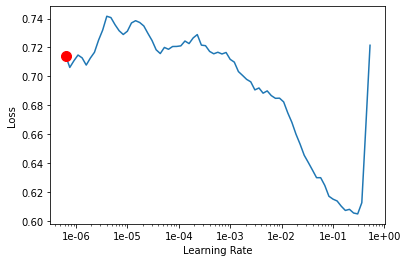

In [ ]:
# Creating the learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[rmse])
# Loading the encoder we just saved
learn.load_encoder('ft_enc')
# Using lr_find to pick a learning rate:
learn.lr_find()
learn.recorder.plot(suggestion=True)

We could do this in stages, picking a learning rate at each stage, gradually unfreezing and training our model. But here I'll just do a rough first pass with some learning rates that are pretty much just guesses:

In [ ]:
# Lots of room to optimize here
learn.fit_one_cycle(2, 1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3/2., 5e-3))
learn.unfreeze()
learn.fit_one_cycle(8, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.408922,0.388217,0.618519,00:03
1,0.372963,0.376649,0.610002,00:03


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.364128,0.378104,0.610888,00:04
1,0.341824,0.362447,0.596669,00:04
2,0.308411,0.355083,0.590309,00:04


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.289866,0.352724,0.587997,00:08
1,0.279483,0.354678,0.589670,00:08
2,0.263848,0.356244,0.590417,00:08
3,0.232595,0.348897,0.584643,00:08
4,0.209547,0.353752,0.588064,00:08
5,0.190320,0.349932,0.584656,00:08
6,0.174233,0.356348,0.589636,00:08
7,0.165692,0.360438,0.593117,00:08


In [ ]:
# Save and see how we do
preds, y = learn.get_preds(DatasetType.Test)
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':[p[0] for p in preds.numpy()]
})
sub.to_csv('fastai_2nd_try_lm.csv', index=False)
sub.head()

,tweet_id,label
0,00BHHHP1,0.352108
1,00UNMD0E,0.577899
2,01AXPTJF,0.398042
3,01HOEQJW,1.351928
4,01JUKMAO,0.114119


Now we're talking! By tuning the language model first, we get a learner more suited to our task and we end up scoring 0.588. This already puts us top 30 out of 250+ entrants, and this model is a single LSTM that can make predictions VERY quickly compared to the larger transformers used by the winning entrants. Note we spent almost no time training, guessed some numbers for lr etc, and basically just threw this together. I think that with a bit more time spent this could get a competitive model going. BUT transformer models are the rage, and so let's move on to trying some of those to see how much better we can get.

# 2) Transformers Assemble!

You can start here if you want - this is independant from Section 1.

Background on transformers... [I guess you can google it]

In [ ]:
# Install the simpletransformers library:
# !pip install simpletransformers -q

In [ ]:
# Imports and load the data
import pandas as pd 
from simpletransformers.classification import ClassificationModel

train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
test['label']=0 # We'll fill this in with predictions later

# Get some local validation going
df_valid = train.sample(1000)
df_train = train.loc[~train.tweet_id.isin(df_valid.tweet_id.values)]

train.head(3) # Remind ourselves what the data looks like

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0


Simpletransformers expects a dataframe with a text column and a label column. We tell it what model we want (there is a wide selection) and specify things like the number of epochs and the learning rate with a dictionary of arguments. This example comes pretty much vebatim from their readme on github...

In [ ]:
# Model arguments:
args = {"reprocess_input_data": True, "overwrite_output_dir": True, 
        'fp16':False,
        "num_train_epochs": 3,
        "learning_rate": 1e-4,
        "max_seq_length": 128, 
        'regression': True} # Regression is this simple! 

# Just the text and labels
df_train = df_train[['safe_text', 'label']]
df_valid = df_valid[['safe_text', 'label']]

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased",num_labels=1,args=args
)

# Train the model
model.train_model(df_train)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_valid)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:745: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
# RMSE scoring on our validation set:
from sklearn.metrics import mean_squared_error as skmse
skmse(df_valid['label'], model_outputs)**0.5

0.5860418579448166

In [ ]:
# Saving Predictions
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':model.predict(test['safe_text'].values)[0]
})
sub.to_csv('transfomer_1.csv', index=False)

This scores ~0.6 on the LB. Again, we've picked an arbitrary lr and num_epocs based on our desire to try something quickly. Some ways to improve:


*   Try a different model. Roberta seems to be the favourite
*   Train a bit more.
*   Ensemble! Why use just one model...

Want to use fastai's goodness with transformers? You can mash the two together! Check out https://github.com/morganmcg1/fasthugs or seach around for examples. I think this will be the way to go to really nail this type of contest.



# 3) Ensemble Like The Cool Kids

An ensemble built from a few different models can do better than any of its constituents. Let's take our three submissions and combine, paying more attention to the better ones, and submit that to see if it improves our situation...

In [ ]:
s1 = pd.read_csv('/content/first_try_fastai_20_epochs.csv')
s2 = pd.read_csv('/content/fastai_2nd_try_lm.csv')
s3 = pd.read_csv('/content/transfomer_1.csv')
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':s1['label']*0.15 + s2['label']*0.35 + s3['label']*0.5
})
sub.to_csv('fancy_ensemble.csv', index=False)

### 0.56! Just for combining three different sets of predictions!!! 

You can see why this is a popular approach. Imagine if we actually put effort into our models, and trained 5 or 10 different ones in different ways.... 

# 4) Conclusion

So, there are a few solutions to the challenge. Unsuprisingly, an ensemble of deep learning models does very well. But I'm always conflicted by this - in the real world, no-one wants to deplot 15 models if one simple one will do almost as well. A single well-tuned LSTM does decently - and while the competition framework encourages hoards of fancy transformers I really think that for most real problems that approach is overkill. 

Musings aside, I hope this is helpful :) Please let me know if you use this, and reach out if you have any questions. I am @johnowhitaker on Zindi, twitter, gmail, yahoo.... 

Happy Hacking :)